Movies Recomendation System

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances

# Gathering and Preparing Data

In [3]:
ratings = pd.read_csv('ratings.csv')

In [4]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [5]:
len(ratings.movieId.unique())

9724

In [6]:
tags = pd.read_csv('tags.csv')

In [7]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [8]:
movies = pd.read_csv('movies.csv')

In [9]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

In [10]:
final = movies.merge(ratings, on='movieId')

In [11]:
final.title = final.title.str.slice(0, -7)

In [12]:
final

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",1,4.0,964982703
1,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",5,4.0,847434962
2,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",7,4.5,1106635946
3,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",15,2.5,1510577970
4,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic,"['Action', 'Animation', 'Comedy', 'Fantasy']",184,4.0,1537109082
100832,193583,No Game No Life: Zero,"['Animation', 'Comedy', 'Fantasy']",184,3.5,1537109545
100833,193585,Flint,['Drama'],184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple,"['Action', 'Animation']",184,3.5,1537110021


# EDA

In [ ]:
final

In [18]:
final['title'] = final['title'].fillna("").astype('str')
title_corpus = ' '.join(final['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

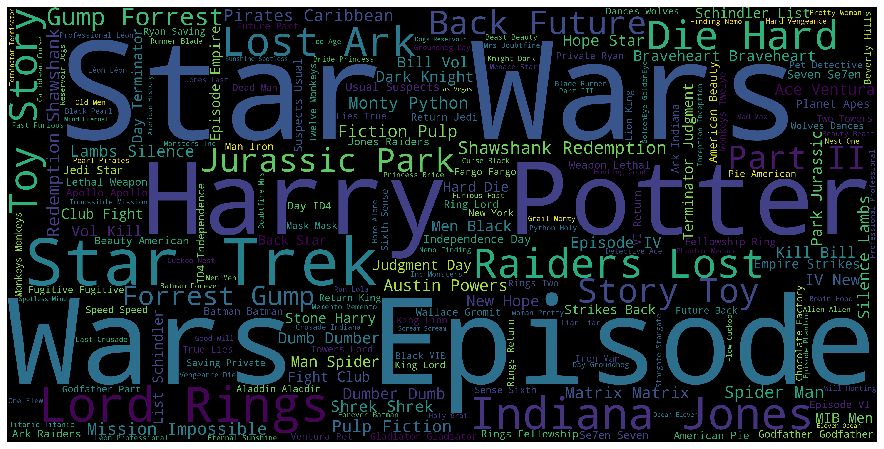

In [19]:
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [20]:
tags.tag = tags.tag.fillna("").astype('str')
title_corpus = ' '.join(tags['tag'])
title_wordcloud2 = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

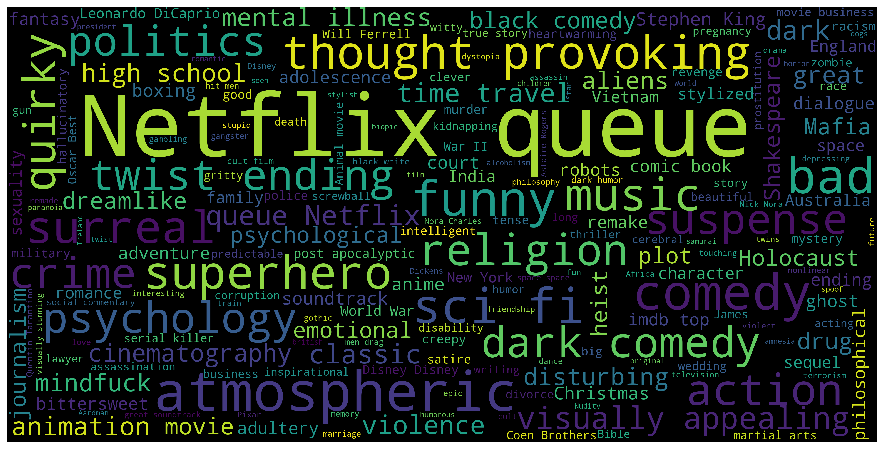

In [21]:
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud2)
plt.axis('off')
plt.show()

In [22]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Text(0, 0.5, 'Count')

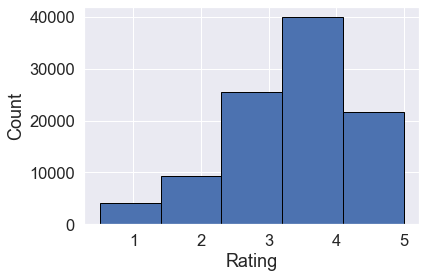

In [23]:
plt.hist(ratings['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')

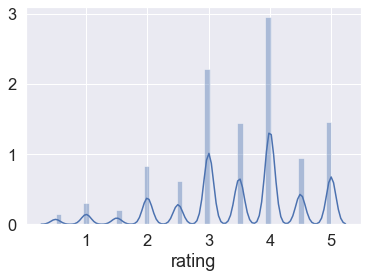

In [24]:
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

In [25]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences

[["['Drama']", 1053],
 ["['Comedy']", 946],
 ["['Comedy', 'Drama']", 435],
 ["['Comedy', 'Romance']", 363],
 ["['Drama', 'Romance']", 349],
 ["['Documentary']", 339],
 ["['Comedy', 'Drama', 'Romance']", 276],
 ["['Drama', 'Thriller']", 168],
 ["['Horror']", 167],
 ["['Horror', 'Thriller']", 135],
 ["['Crime', 'Drama']", 134],
 ["['Crime', 'Drama', 'Thriller']", 125],
 ["['Drama', 'War']", 114],
 ["['Comedy', 'Crime']", 101],
 ["['Action', 'Comedy']", 92],
 ["['Thriller']", 84],
 ["['Children', 'Comedy']", 74],
 ["['Comedy', 'Horror']", 69],
 ["['Action', 'Crime', 'Thriller']", 66],
 ["['Action', 'Adventure', 'Sci-Fi']", 66],
 ["['Action', 'Drama']", 62],
 ["['Action', 'Crime', 'Drama', 'Thriller']", 61],
 ["['Action']", 60],
 ["['Action', 'Thriller']", 60],
 ["['Horror', 'Sci-Fi']", 53],
 ["['Action', 'Crime', 'Drama']", 50],
 ["['Crime', 'Thriller']", 45],
 ["['Drama', 'Musical']", 44],
 ["['Action', 'Drama', 'Thriller']", 43],
 ["['Action', 'Sci-Fi', 'Thriller']", 43],
 ["['Horror', 

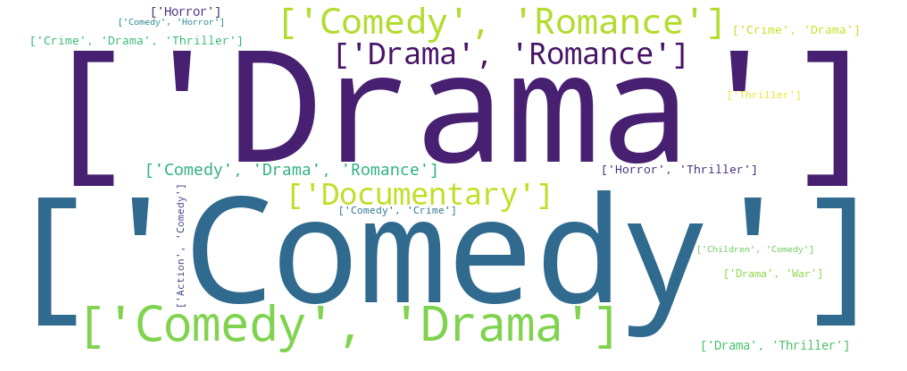

In [26]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
movies['genres'].astype(str)

# Model Building

## Content Based

In [13]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(final['genres'])
tfidf_matrix.shape

(100836, 177)

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

In [ ]:
titles = movies.title
indicies = pd.Series(movies.index, index=movies['title'])

def genre_rec(title):
    idx = indicies[title]
    similar_score = list(enumerate(cosine_sim[idx]))
    similar_score = sorted(similar_score, key=lambda x: x[1], reverse=True)
    similar_score = similar_score[1:21]
    movie_indices = [i[0] for i in similar_score]
    return titles.iloc[movie_indices]

In [ ]:
genre_rec('Toy Story (1995)').head(5)

## Collaberative Filtering Recomendation Model

In [ ]:
train_data, test_data = train_test_split(final, test_size=0.2)

In [ ]:
train_data_matrix = train_data.as_matrix(columns = ['userId', 'movieId', 'rating'])
test_data_matrix = test_data.as_matrix(columns = ['userId', 'movieId', 'rating'])

In [ ]:
# User:
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0

In [ ]:
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0